In [653]:
# 표준 라이브러리
import os
import io
import sys
import json
import inspect
from typing import List, Dict, Any, Tuple, Callable, Sequence, Optional

# 써드파티 라이브러리 - img2table
from img2table.document import Image as Img2TableImage
from img2table.ocr import PaddleOCR as I2T_PaddleOCR

# 써드파티 라이브러리 - OCR 엔진
from paddleocr import PaddleOCR as PaddleEngine

# 써드파티 라이브러리 - 이미지/과학 계산
import numpy as np
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# 프로젝트 루트 경로를 Python path에 추가
project_root = os.path.abspath('/home/aidan/work/meow-chat')
if project_root not in sys.path:
    sys.path.append(project_root)

# 프로젝트 내부 모듈 - 이미지 전처리 함수들
try:
    from app.services.analysis.image_preprocessing import (
        # 공통 함수들
        pdf_to_images, open_with_exif, save_png_bytes, apply_pipeline,
        
        # 전처리 함수들
        flatten_transparency, auto_crop_with_margin, normalize_mode,
        upscale_min_resolution, illumination_flatten, suppress_glare,
        weak_autocontrast, apply_clahe, conservative_sharpen, blacken_reddish_text, blacken_bluish_text, to_grayscale,
        adaptive_binarize_for_ocr, enhance_table_lines, table_smart_crop,
        add_white_border, downscale_target_long_edge, ocr_quality_gate,
        
        # 고급 전처리 함수들 (필요시)
        detect_document_quad, perspective_unwarp, deskew_textlines,
        conditional_dewarp
    )
    print("✅ 이미지 전처리 함수들 import 완료!")
except ImportError as e:
    print(f"❌ Import 오류: {e}")
    print("📂 현재 sys.path:", sys.path[-3:])

# PaddleOCR 생성자의 파라미터 확인 (paddleocr 엔진)
signature = inspect.signature(PaddleEngine.__init__)
print(f"\n📋 지원하는 파라미터:")
for param_name, param in signature.parameters.items():
    if param_name != 'self':
        default = param.default if param.default != inspect.Parameter.empty else "필수"
        print(f"   {param_name}: {default}")
        
print("📦 라이브러리 로드 완료!")

✅ 이미지 전처리 함수들 import 완료!

📋 지원하는 파라미터:
   doc_orientation_classify_model_name: None
   doc_orientation_classify_model_dir: None
   doc_unwarping_model_name: None
   doc_unwarping_model_dir: None
   text_detection_model_name: None
   text_detection_model_dir: None
   textline_orientation_model_name: None
   textline_orientation_model_dir: None
   textline_orientation_batch_size: None
   text_recognition_model_name: None
   text_recognition_model_dir: None
   text_recognition_batch_size: None
   use_doc_orientation_classify: None
   use_doc_unwarping: None
   use_textline_orientation: None
   text_det_limit_side_len: None
   text_det_limit_type: None
   text_det_thresh: None
   text_det_box_thresh: None
   text_det_unclip_ratio: None
   text_det_input_shape: None
   text_rec_score_thresh: None
   return_word_box: None
   text_rec_input_shape: None
   lang: None
   ocr_version: None
   kwargs: 필수
📦 라이브러리 로드 완료!


In [654]:
from importlib.metadata import version, PackageNotFoundError
from img2table.ocr import PaddleOCR as I2T_PaddleOCR

print("img2table OCR wrapper module:", I2T_PaddleOCR.__module__)

try:
    print("paddleocr version:", version("paddleocr"))
except PackageNotFoundError:
    import paddleocr
    print("paddleocr version:", getattr(paddleocr, "__version__", "unknown"))

img2table OCR wrapper module: img2table.ocr.paddle
paddleocr version: 3.2.0


In [655]:
# img2table를 사용할 때는 img2table 전용 OCR wrapper(I2T_PaddleOCR)를 사용해야 합니다.

# img2table용 OCR 생성 (paddleocr 엔진을 내부에서 사용)
i2t_ocr = I2T_PaddleOCR(lang='korean')

# 날짜 추출용 ocr
paddle_ocr = PaddleEngine(
    lang='korean', 
    use_angle_cls=True,
    use_doc_orientation_classify=True, # 문서 방향 분류/교정 모델 로드
    use_doc_unwarping=True,            # 문서 휘어짐 보정 
    # use_textline_orientation=True,     # 방향 분류 활성화
    # text_det_thresh=0.2,               # 감지 임계값 
    # text_rec_score_thresh=0.7,         # 인식 임계값 
    # text_recognition_batch_size=1,     # 배치 크기 
    # text_det_limit_side_len=1600,      # 이미지 크기 
    # return_word_box=True,              # 단어별 박스 반환       
    # text_det_unclip_ratio=2.5,         # 텍스트 박스 확장  
)     

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('korean_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/korean_PP-OCRv5_mobile_rec`.
/tmp/ipykernel_1399293/3109793940.py:7: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future.

In [656]:
# img_path = os.path.abspath('notebooks/ocr/assets/images/test_image_1.jpg')

# img_path = os.path.abspath('notebooks/ocr/assets/images/20241106.jpg')   # ---------- 날짜가 여러개
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241107_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241107.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241121_2.png')  # ---------- 날짜 없는것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241121.png')    # ---------- 사진으로 짝어서 삐뚤어진것 값 안나옴. 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241123_2.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241123.png')    # ---------- 인쇄일자만 있음
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241205_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241205.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241219.png')    # ---------- 사진으로 짝어서 삐뚤어진것
img_path = os.path.abspath('notebooks/ocr/assets/images/20241221_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241221.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241224_2.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241224.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241231.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250107.png')    # ----------
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250110.png')    # ---------- 데이블 구조 특이한것. value 열 레이블이 날짜임
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_2.png')  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_3.png')  # ---------- blue 글자 인식이 잘 안됨
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_4.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119_2.png')  # ---------- 흐릿한 이미지
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119_3.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119.png')    # ---------- 흐릿한 이미지
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류 RDW-CV  RETIC#
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250203.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250207.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250209.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250216.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250222.png') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250228.png') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250301.png')



# img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg')



print(f"분석할 이미지: {img_path}")    

분석할 이미지: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241221_2.jpg


In [657]:
def preprocess(
    img_bytes: bytes,    
    debug: bool = True,
) -> bytes:
    try:
        if debug:
            print("🏥 의료 문서용 전처리 시작")
        
        img = open_with_exif(img_bytes) # EXIF 회전 교정
        original_size = img.size
        
        if debug:
            print(f"📏 원본 이미지 크기: {original_size}")
        
        steps = [
            # 기본 정리 (필수 선행 단계)
            (flatten_transparency, {}),              # 투명도 제거
            (normalize_mode, {}),                    # 모드 표준화 (L/RGB)
            
            # 기하학적 보정 (픽셀 수준 작업)
            # (auto_crop_with_margin, {}),           # 여백 제거
            (conditional_dewarp, {}),                # 페이지 휘어짐 보정 
            (deskew_textlines, {}),                  # 미세 기울기 보정
          
            # 해상도 표준화 (최소 품질 확보)
            (upscale_min_resolution, {}),            
            
            # 빛반사 제거
            (suppress_glare, {}),                   
            
            # 대비 향상
            (weak_autocontrast, {}),               
            
            # 색 텍스트 보정(있으면)
            (blacken_reddish_text, {}),  
            (blacken_bluish_text, {}), 

            # 회색화
            (to_grayscale, {}),                   

            # 표 라인 강화
            (enhance_table_lines, {}), 
            
            # 최종 크기 조정 (토큰 절약)
            (downscale_target_long_edge, {}),      

            # 선명도 향상
            (conservative_sharpen, {}),           
        ]
    
        # 파이프라인 실행
        img = apply_pipeline(img, steps)
        
        # PNG로 저장
        buf = io.BytesIO()
        if img.mode == 'L':  # 그레이스케일
            img.save(buf, format="JPEG", quality=85, optimize=True)
        else:  # RGB
            img.save(buf, format="JPEG", quality=85, optimize=True, subsampling=2)
        result_bytes = buf.getvalue()
        
        if debug:
            final_size = img.size
            print(f"📐 최종 이미지 크기: {final_size}")
            print(f"🔄 크기 변화: {original_size} → {final_size}")
            # 용량 변화 및 퍼센트 계산
            original_bytes = len(img_bytes)
            result_bytes_len = len(result_bytes)
            percentage = (result_bytes_len / original_bytes) * 100
            
            print(f"💾 용량 변화: {original_bytes:,} bytes → {result_bytes_len:,} bytes ({percentage:.1f}%)")
            print("✅ 전처리 완료")
        
        return result_bytes
        
    except Exception as e:
        if debug:
            print(f"❌ 전처리 실패: {e}")
            import traceback
            traceback.print_exc()
        
        print(f"⚠️ 전처리 실패, 원본 반환: {e}")
        return img_bytes 

In [658]:
# 이미지 파일을 읽고 전처리하여 바이트로 변환
with open(img_path, 'rb') as f:
    _raw_bytes = f.read()

_pre_bytes = preprocess(_raw_bytes, debug=True)

🏥 의료 문서용 전처리 시작
📏 원본 이미지 크기: (794, 1123)
[conditional_dewarp] r2_lin=0.032, r2_quad=0.142, gain=0.111, amp=564.85px
[conditional_dewarp] 곡률/적합 품질 부족 - 스킵
[deskew_textlines] Tesseract OSD 실패: (1, 'Tesseract Open Source OCR Engine v4.1.1 with Leptonica Warning: Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 123 Warning. Invalid resolution 0 dpi. Using 70 instead. Too few characters. Skipping this page Error during processing.'), Hough 변환으로 대체
[deskew_textlines] Hough angle: -0.20°
[deskew_textlines] coarse=-0.20°, final=0.00°
📐 최종 이미지 크기: (1273, 1800)
🔄 크기 변화: (794, 1123) → (1273, 1800)
💾 용량 변화: 69,559 bytes → 106,903 bytes (153.7%)
✅ 전처리 완료


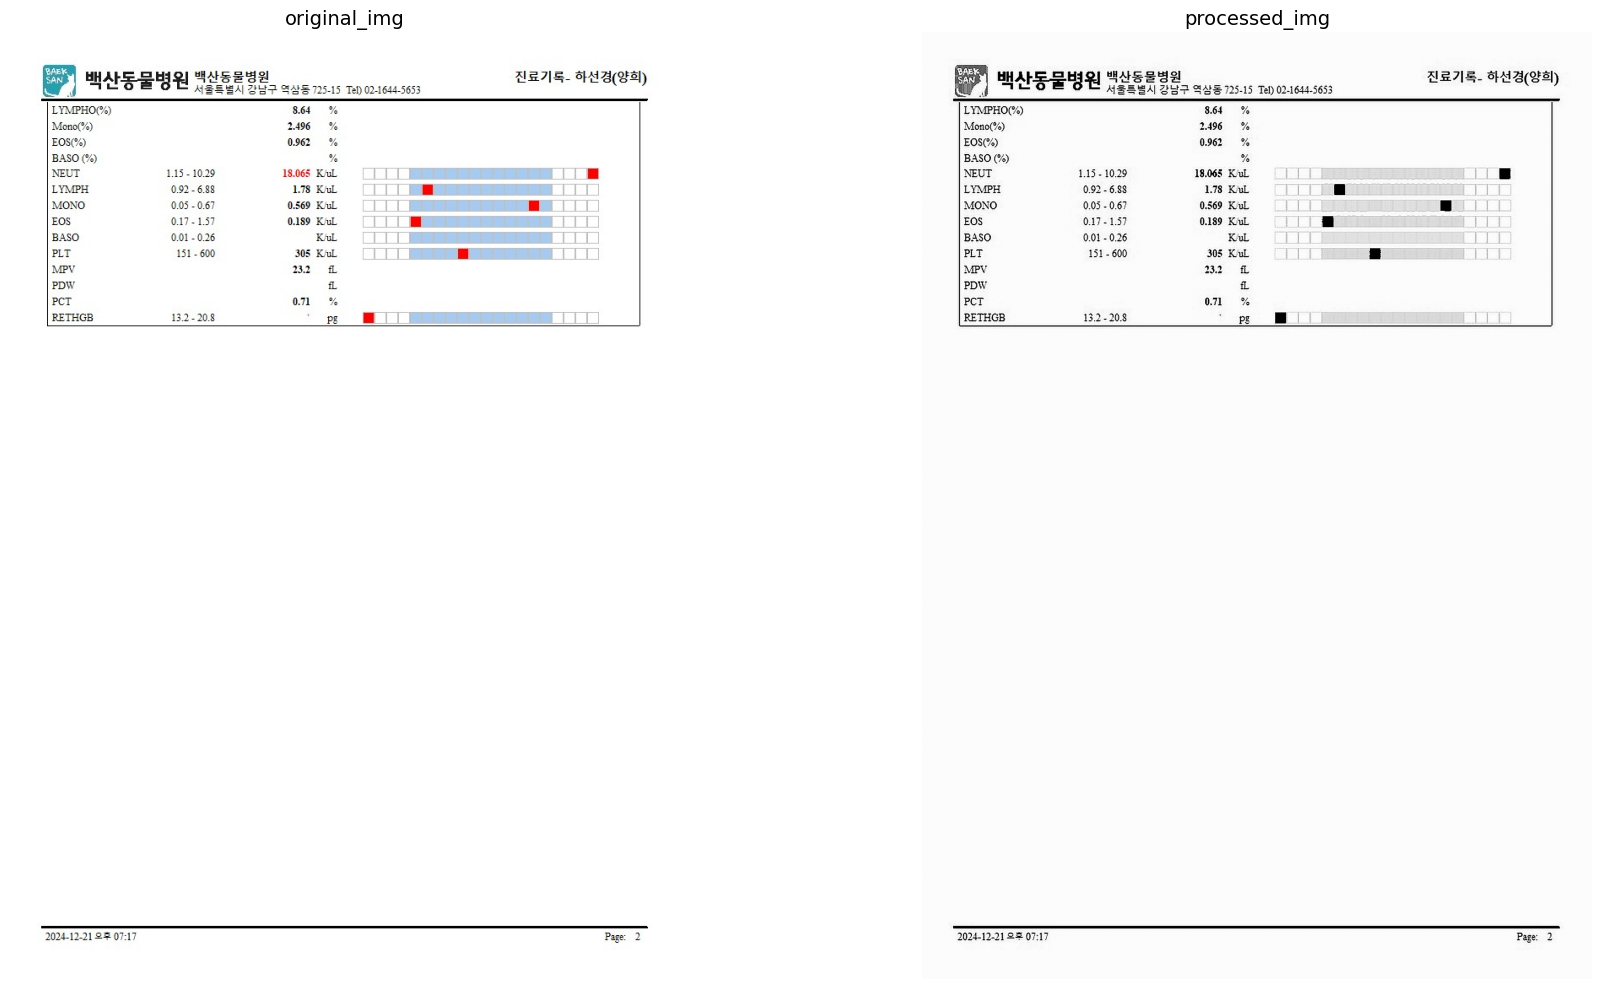

In [659]:
# bytes를 PIL Image로 변환
processed_img = PILImage.open(io.BytesIO(_pre_bytes))

# 원본과 전처리된 이미지를 함께 표시
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 원본 이미지
original_img = PILImage.open(img_path)
axes[0].imshow(original_img)
axes[0].set_title('original_img', fontsize=14)
axes[0].axis('off')

# 전처리된 이미지
if processed_img.mode == 'L':  # 그레이스케일
    axes[1].imshow(processed_img, cmap='gray', vmin=0, vmax=255)
else:  # 컬러
    axes[1].imshow(processed_img)
axes[1].set_title('processed_img', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [660]:
import re
from datetime import datetime
import unicodedata

def extract_exam_date(
    paddle_ocr,
    pre_bytes: bytes,
    top_ratio: float = 0.2,
    score_threshold: float = 0.7,
    visualize: bool = True,
) -> str:
    """
    전처리된 이미지에서 상단 영역(top_ratio 비율)만 OCR 후 가장 위에 존재하는 날짜를 YYYY-MM-DD로 반환.

    지원 포맷:
      - YYYY-MM-DD / YYYY.MM.DD / YYYY/MM/DD
      - YYYY년 M월 D일
      - M-D-YYYY / M.D.YYYY / M/D/YYYY
      - M월 D일 YYYY년
      - YYYYMMDD (연속 8자리)

    선택 규칙:
      1) OCR 텍스트별 점수(score_threshold 이상)만 고려
      2) 날짜 후보 추출 후 (y, x) 오름차순 정렬 (화면상 가장 위, 그 다음 가장 왼쪽)
      3) 첫 번째 후보 반환. 없으면 빈 문자열

    Parameters:
        paddle_ocr: PaddleOCR (paddlex) 객체
        pre_bytes: 전처리된 이미지 bytes
        top_ratio: 상단 영역 비율 (0~1)
        score_threshold: OCR 텍스트 신뢰도 임계값
        visualize: True면 상단 crop 시각화
    """
    try:
        from PIL import Image as PILImage
        import numpy as np
        import cv2
        import io
        # plt 는 노트북 상단에서 이미 import 되었음을 가정 (matplotlib.pyplot as plt)
        # 없으면 안전하게 lazy import
        if visualize:
            try:
                import matplotlib.pyplot as plt  # noqa: F401
            except Exception:
                visualize = False

        # 상단 영역 추출
        img = PILImage.open(io.BytesIO(pre_bytes))
        w, h = img.size
        top_h = int(h * top_ratio)
        crop_img = img.crop((0, 0, w, top_h))

        if visualize:
            plt.figure(figsize=(10, 4))
            plt.imshow(crop_img, cmap='gray' if crop_img.mode == 'L' else None)
            plt.title(f'Top {int(top_ratio*100)}% Region')
            plt.axis('off')
            plt.show()

        # JPEG 인코딩 후 OpenCV 배열 변환
        buf = io.BytesIO()
        crop_img.save(buf, format='JPEG', quality=90)
        nparr = np.frombuffer(buf.getvalue(), np.uint8)
        cv_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # OCR 실행
        ocr_result = paddle_ocr.predict(cv_image)

        # 텍스트/위치 수집
        texts_with_pos = []  # (text, score, y_min, x_min)
        if ocr_result and len(ocr_result) > 0:
            ocr_obj = ocr_result[0]
            rec_texts = ocr_obj.get('rec_texts', [])
            rec_scores = ocr_obj.get('rec_scores', [])
            rec_boxes = ocr_obj.get('rec_boxes', [])  # [x_min, y_min, x_max, y_max]
            for idx, (t, s) in enumerate(zip(rec_texts, rec_scores)):
                if idx < len(rec_boxes):
                    box = rec_boxes[idx]
                    x_min, y_min = int(box[0]), int(box[1])
                else:
                    x_min, y_min = 0, 10_000
                texts_with_pos.append((t, float(s), y_min, x_min))

        # 정규화 준비
        dash_pattern = re.compile('[\u2010\u2011\u2012\u2013\u2014\u2015\u2212\u30FC\uFF0D]')
        def normalize_text(t: str) -> str:
            if not t:
                return ''
            nt = unicodedata.normalize('NFKC', t)
            nt = dash_pattern.sub('-', nt)
            nt = nt.replace('：', ':')
            nt = re.sub('\s+', ' ', nt.strip())
            return nt

        date_regexes = [
            re.compile(r'(?P<y>\d{4})[./-](?P<m>\d{1,2})[./-](?P<d>\d{1,2})'),
            re.compile(r'(?P<y>\d{4})\s*년\s*(?P<m>\d{1,2})\s*월\s*(?P<d>\d{1,2})\s*일'),
            re.compile(r'(?P<m>\d{1,2})[./-](?P<d>\d{1,2})[./-](?P<y>\d{4})'),
            re.compile(r'(?P<m>\d{1,2})\s*월\s*(?P<d>\d{1,2})\s*(?P<y>\d{4})\s*년'),
            re.compile(r'(?P<y>20\d{2}|19\d{2})(?P<m>0[1-9]|1[0-2])(?P<d>0[1-9]|[12]\d|3[01])')
        ]

        candidates = []  # (date_str, y, x)
        for raw_text, score, y, x in texts_with_pos:
            if score < score_threshold:
                continue
            norm = normalize_text(raw_text)
            if not norm:
                continue
            if re.fullmatch(r'\d{9,}', norm):  # 9자리 이상 숫자열은 잡음으로 간주
                continue
            for rx in date_regexes:
                for m in rx.finditer(norm):
                    try:
                        yv = int(m.group('y'))
                        mv = int(m.group('m'))
                        dv = int(m.group('d'))
                        datetime(yv, mv, dv)  # 유효성 검사
                        candidates.append((f"{yv:04d}-{mv:02d}-{dv:02d}", y, x))
                    except Exception:
                        continue

        if not candidates:
            return ''
        candidates.sort(key=lambda c: (c[1], c[2]))
        return candidates[0][0]

    except Exception:
        return ''

In [661]:
def extract_tables(i2t_ocr, pre_bytes: bytes):
    """
    전처리된 이미지 바이트에서 테이블을 추출하여 _tables 객체를 반환
    
    Args:
        i2t_ocr: img2table용 OCR 객체
        pre_bytes: 전처리된 이미지 바이트
        
    Returns:
        list: img2table에서 추출된 테이블 객체 리스트
    """
    # 전처리된 바이트를 BytesIO로 감싸 전달 (Img2TableImage는 str/Path/BytesIO/bytes를 지원)
    _pre_io = io.BytesIO(pre_bytes)
    _pre_io.seek(0)

    # 표 추출: BytesIO를 직접 전달
    _doc = Img2TableImage(src=_pre_io, detect_rotation=True)

    # 경계선 없는 표/암시적 행열 허용 + OCR 신뢰도 하향
    return _doc.extract_tables(
        ocr=i2t_ocr,
        implicit_rows=True,
        implicit_columns=True,
        borderless_tables=True,
        min_confidence=75,
    )

In [662]:
    # 표를 JSON으로 변환
    # json_tables = []
    # for idx, table in enumerate(_tables):
    #     df = table.df.fillna("UNKNOWN")  # 빈 셀을 UNKNOWN 으로 채움
    #     json_tables.append({
    #         "table_index": idx + 1,
    #         "rows": df.values.tolist()
    #     })

    # # tables만 포함하여 JSON 출력
    # result_payload = {
    #     "tables": json_tables,
    # }

    # json_output = json.dumps(result_payload, ensure_ascii=False, indent=2)

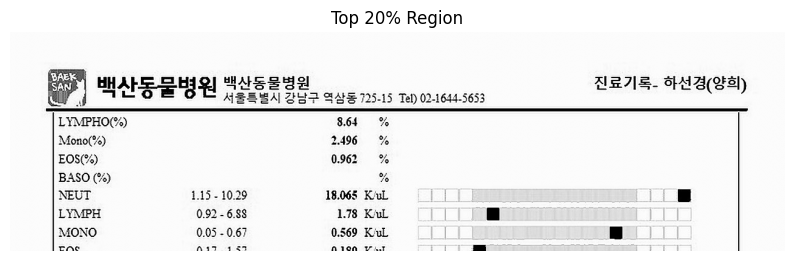

검사일자: 


In [663]:
# 함수 사용 예시
inspection_date = extract_exam_date(paddle_ocr, _pre_bytes)
print(f"검사일자: {inspection_date}")

In [ ]:
# 테이블 추출 결과 분석
tables_result = extract_tables(i2t_ocr, _pre_bytes)
print(f"추출된 테이블 수: {len(tables_result)}")
print()

for idx, table in enumerate(tables_result):
    print(f"=== 테이블 {idx + 1} ===")
    print(f"제목: {table.title}")
    print(f"위치: {table.bbox}")
    print(f"크기: {table.shape}")
    print(f"신뢰도: {table.confidence}")
    print("\nDataFrame 내용:")
    print(table.df)
    print("\n" + "="*50 + "\n")

[ExtractedTable(title=BAEK
진료기록-하선경(양희)
백산동물병원
SAN
서울특별시강남구역삼동725-15 Tel)02-1644-5653, bbox=(71, 129, 646, 558),shape=(14, 4))]


In [665]:
# 다른 파라미터로 테이블 추출 시도
def extract_tables_enhanced(i2t_ocr, pre_bytes: bytes):
    """향상된 테이블 추출"""
    _pre_io = io.BytesIO(pre_bytes)
    _pre_io.seek(0)
    _doc = Img2TableImage(src=_pre_io, detect_rotation=True)
    
    # 더 관대한 설정으로 테이블 추출
    return _doc.extract_tables(
        ocr=i2t_ocr,
        implicit_rows=True,          # 암시적 행 허용
        implicit_columns=True,       # 암시적 열 허용  
        borderless_tables=True,      # 경계선 없는 테이블 허용
        min_confidence=50,           # 신뢰도 더 낮춤 (75 → 50)
        # 추가 설정들
    )

print("=== 향상된 설정으로 재시도 ===")
enhanced_tables = extract_tables_enhanced(i2t_ocr, _pre_bytes)
print(f"추출된 테이블 수: {len(enhanced_tables)}")

for idx, table in enumerate(enhanced_tables):
    print(f"\n테이블 {idx + 1}:")
    print(f"크기: {table.shape}, 신뢰도: {table.confidence}")
    print(table.df)

=== 향상된 설정으로 재시도 ===
추출된 테이블 수: 1

테이블 1:
추출된 테이블 수: 1

테이블 1:


AttributeError: 'ExtractedTable' object has no attribute 'shape'

In [666]:
# OCR로 전체 텍스트 추출해서 검사 결과 확인
def extract_all_text_ocr(paddle_ocr, pre_bytes: bytes):
    """전체 이미지에서 OCR로 텍스트 추출"""
    img = PILImage.open(io.BytesIO(pre_bytes))
    
    # JPEG 인코딩 후 OpenCV 배열 변환
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=90)
    nparr = np.frombuffer(buf.getvalue(), np.uint8)
    cv_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # OCR 실행
    ocr_result = paddle_ocr.predict(cv_image)
    
    if ocr_result and len(ocr_result) > 0:
        ocr_obj = ocr_result[0]
        rec_texts = ocr_obj.get('rec_texts', [])
        rec_scores = ocr_obj.get('rec_scores', [])
        
        print("=== OCR로 추출된 모든 텍스트 ===")
        for text, score in zip(rec_texts, rec_scores):
            if score > 0.5:  # 신뢰도 50% 이상만
                print(f"{text} (신뢰도: {score:.3f})")

# OCR로 모든 텍스트 확인
print("검사 결과가 OCR로는 잘 추출되는지 확인:")
extract_all_text_ocr(paddle_ocr, _pre_bytes)

검사 결과가 OCR로는 잘 추출되는지 확인:
=== OCR로 추출된 모든 텍스트 ===
BAEK (신뢰도: 0.897)
백산동물병원 (신뢰도: 1.000)
진료기록-하선경(양희) (신뢰도: 0.940)
SAN (신뢰도: 0.995)
서울특별시 강남구 역삼동725-15 Tel) 02-1644-5653 (신뢰도: 0.936)
LYMPHO(%) (신뢰도: 0.969)
8.64 (신뢰도: 0.999)
% (신뢰도: 0.994)
Mono(%) (신뢰도: 0.999)
2.496 (신뢰도: 0.999)
% (신뢰도: 0.999)
EOS(%) (신뢰도: 0.985)
0.962 (신뢰도: 0.999)
% (신뢰도: 0.999)
BASO (%) (신뢰도: 0.885)
% (신뢰도: 1.000)
NEUT (신뢰도: 0.997)
1.15 - 10.29 (신뢰도: 0.936)
18.065 KuL (신뢰도: 0.983)
LYMPH (신뢰도: 0.996)
0.92-6.38 (신뢰도: 0.926)
1.78 KuL (신뢰도: 0.951)
MONO (신뢰도: 0.981)
0.05-0.67 (신뢰도: 0.992)
0.569 KuL (신뢰도: 0.978)
EOS (신뢰도: 0.946)
0.17-1.57 (신뢰도: 0.962)
0.189 KuL (신뢰도: 0.944)
BASO (신뢰도: 0.991)
0.01-0.26 (신뢰도: 0.999)
KuL (신뢰도: 0.957)
PLT (신뢰도: 0.996)
151-600 (신뢰도: 0.998)
305 KuL (신뢰도: 0.956)
MPV (신뢰도: 0.982)
23.2 (신뢰도: 0.996)
fL (신뢰도: 0.698)
PDW (신뢰도: 0.827)
fL (신뢰도: 0.765)
PCT (신뢰도: 0.984)
0.71 (신뢰도: 0.995)
% (신뢰도: 0.999)
RETHGB (신뢰도: 0.996)
13.2-20.8 (신뢰도: 0.988)
pg (신뢰도: 0.855)
=== OCR로 추출된 모든 텍스트 ===
BAEK (신뢰도: 0.897)
백산동물병원